# Proyek Klasifikasi Gambar: [Vegetable Dataset]
- **Nama:** Ester Tri Wahyuningsih
- **Email:** estertriw16@gmail.com
- **ID Dicoding:** MC002D5X0841

## Import Semua Packages/Library yang Digunakan

In [1]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
import shutil
from google.colab import files

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
from collections import Counter
from PIL import Image

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

In [3]:
# Upload Files kaggle.json

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"estertriwahyuningsih","key":"956e62e00890e29a64abc1f569b792a8"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp "kaggle.json" ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Unduh dataset dari Kaggle
!kaggle datasets download -d misrakahmed/vegetable-image-dataset --force
!ls

# Ekstrak file zip yang diunduh
!unzip vegetable-image-dataset.zip -d vegetables

Streaming output truncated to the last 5000 lines.
  inflating: vegetables/Vegetable Images/train/Radish/0001.jpg  
  inflating: vegetables/Vegetable Images/train/Radish/0002.jpg  
  inflating: vegetables/Vegetable Images/train/Radish/0003.jpg  
  inflating: vegetables/Vegetable Images/train/Radish/0004.jpg  
  inflating: vegetables/Vegetable Images/train/Radish/0005.jpg  
  inflating: vegetables/Vegetable Images/train/Radish/0006.jpg  
  inflating: vegetables/Vegetable Images/train/Radish/0007.jpg  
  inflating: vegetables/Vegetable Images/train/Radish/0008.jpg  
  inflating: vegetables/Vegetable Images/train/Radish/0009.jpg  
  inflating: vegetables/Vegetable Images/train/Radish/0010.jpg  
  inflating: vegetables/Vegetable Images/train/Radish/0011.jpg  
  inflating: vegetables/Vegetable Images/train/Radish/0012.jpg  
  inflating: vegetables/Vegetable Images/train/Radish/0013.jpg  
  inflating: vegetables/Vegetable Images/train/Radish/0014.jpg  
  inflating: vegetables/Vegetable Image

In [5]:
# Direktori train, test, val
train_dir = "vegetables/Vegetable Images/train"
test_dir = "vegetables/Vegetable Images/test"
val_dir = "vegetables/Vegetable Images/validation"

subdirectories = [f.name for f in os.scandir(train_dir) if f.is_dir()]

# Melihat subdirectories (kelas yang tersedia)
print("Daftar Kelas:")
for subdir in subdirectories:
    print(f">>> {subdir}")

Daftar Kelas:
>>> Cabbage
>>> Pumpkin
>>> Potato
>>> Bottle_Gourd
>>> Bitter_Gourd
>>> Tomato
>>> Radish
>>> Cauliflower
>>> Bean
>>> Brinjal
>>> Capsicum
>>> Broccoli
>>> Cucumber
>>> Carrot
>>> Papaya


In [6]:
# Gabungkan test, train, dan validation
combined_dir = "vegetables/Vegetable Images/dataset"

# Buat direktori baru untuk dataset gabungan
os.makedirs(combined_dir, exist_ok=True)

# Salin file dan folder dari train
for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

# Salin file dan folder dari test
for category in os.listdir(test_dir):
    category_dir = os.path.join(test_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

# Salin file dan folder dari validation
for category in os.listdir(val_dir):
    category_dir = os.path.join(val_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

print("Dataset berhasil digabungkan.")

Dataset berhasil digabungkan.


In [7]:
# Menyimpan semua ukuran gambar
image_sizes = []

# Telusuri semua folder dan file gambar
for root, dirs, files in os.walk(combined_dir):
    for file in files:
        if file.endswith(('.jpg', '.jpeg', '.png')):
            try:
                img_path = os.path.join(root, file)
                with Image.open(img_path) as img:
                    image_sizes.append(img.size)  # (width, height)
            except Exception as e:
                print(f"Error opening image {file}: {e}")

# Tampilkan hasil
size_counts = Counter(image_sizes)
for size, count in size_counts.items():
    print(f"Ukuran: {size}")

Ukuran: (224, 224)
Ukuran: (224, 205)
Ukuran: (224, 200)
Ukuran: (224, 193)
Ukuran: (224, 211)
Ukuran: (224, 198)
Ukuran: (224, 207)
Ukuran: (224, 223)
Ukuran: (224, 210)
Ukuran: (224, 187)


Insight : \
Ukuran gambar / resolusi dari gambar bervariasi/tidak seragam sebelum tahap preprocessing.

***Visualisasi Data***

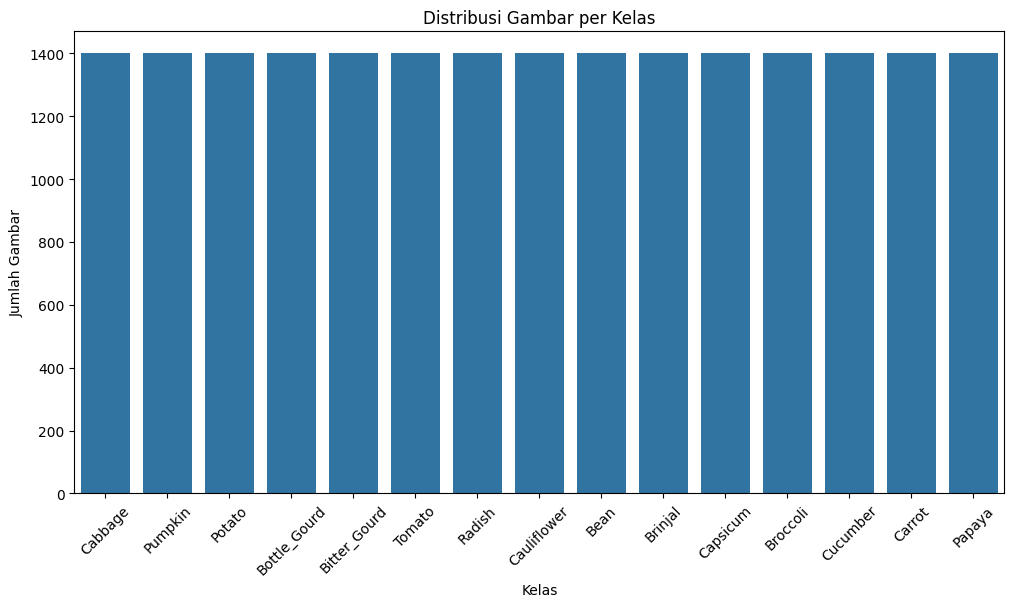

In [8]:
# Ambil daftar kelas
classes = os.listdir(combined_dir)

# Hitung jumlah gambar per kelas
class_counts = {cls: len(os.listdir(os.path.join(combined_dir, cls))) for cls in classes}

# Visualisasi Jumlah gambar setiap kelas
plt.figure(figsize=(12, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xticks(rotation=45)
plt.title('Distribusi Gambar per Kelas')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Gambar')
plt.show()

Insight : \
Terdapat 15 kelas dengan masing-masing kelas memiliki jumlah dataset yang sama yaitu sekitar 1400 dataset

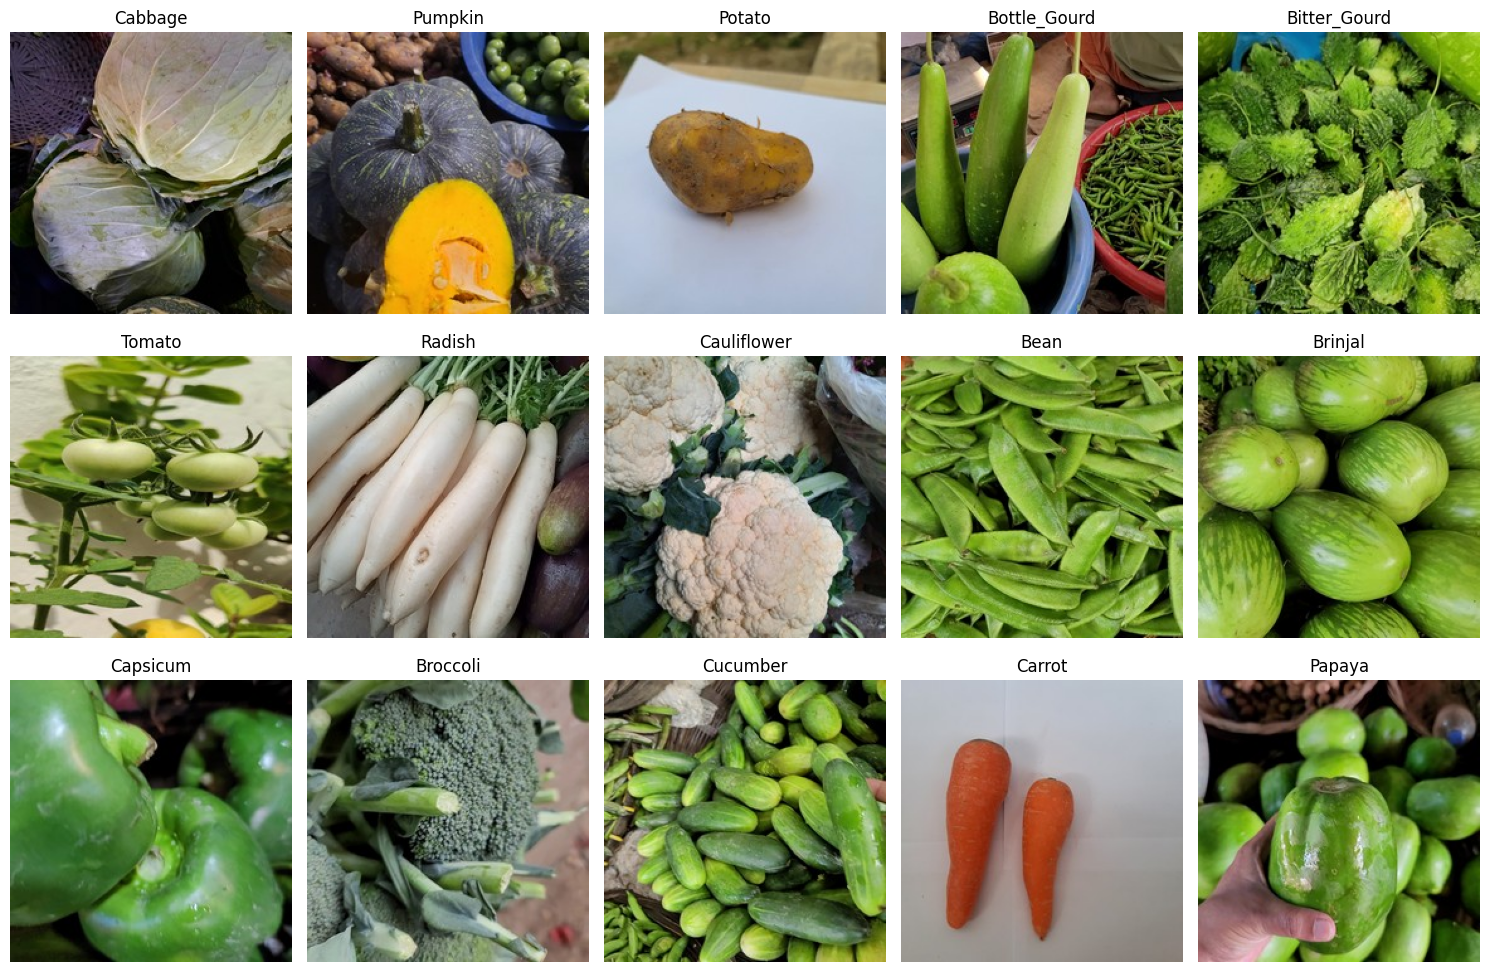

In [9]:
# Visualisasi Contoh Gambar per kelas
def view_random_images(target_dir, class_names):
    plt.figure(figsize=(15, 10))
    for i, class_name in enumerate(class_names):
        img_dir = os.path.join(target_dir, class_name)
        img_file = random.choice(os.listdir(img_dir))
        img_path = os.path.join(img_dir, img_file)
        img = mpimg.imread(img_path)
        plt.subplot(3, 5, i+1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Tampilkan contoh gambar dari setiap kelas
view_random_images(combined_dir, classes)

### Data Preprocessing

#### Split Dataset

In [10]:
image_paths = []
labels = []

for root, dirs, files in os.walk(combined_dir):
    for file in files:
        if file.lower().endswith(('jpg', 'jpeg', 'png')):
            image_paths.append(os.path.join(root, file))
            labels.append(os.path.basename(root))

# Membuat DataFrame
df = pd.DataFrame({'path': image_paths, 'label': labels})

# Pembagian pertama: Train (80%) dan (Test + Validation) (20%)
train_df, test_val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Pembagian kedua: Test (50% dari 20%) dan Validation (50% dari 20%)
test_df, val_df = train_test_split(test_val_df, test_size=0.5, stratify=test_val_df['label'], random_state=42)

# Menambahkan kolom untuk menandakan set
train_df['set'] = 'train'
val_df['set'] = 'validation'
test_df['set'] = 'test'

# Menampilkan ukuran masing-masing set
total_size = len(df)
train_size = len(train_df)
val_size = len(val_df)
test_size = len(test_df)

print(f"Total size: {total_size}")
print(f"Train size: {train_size} ({train_size / total_size * 100:.2f}%)")
print(f"Validation size: {val_size} ({val_size / total_size * 100:.2f}%)")
print(f"Test size: {test_size} ({test_size / total_size * 100:.2f}%)")

Total size: 21000
Train size: 16800 (80.00%)
Validation size: 2100 (10.00%)
Test size: 2100 (10.00%)


In [11]:
# Gabungkan DataFrame
df_all = pd.concat([train_df, test_df, val_df], ignore_index=True)

# Statistik per kelas dan set
print('=====================================================')
print(df_all.groupby(['set', 'label']).size())
print('=====================================================')

set         label       
test        Bean             140
            Bitter_Gourd     140
            Bottle_Gourd     140
            Brinjal          140
            Broccoli         140
            Cabbage          140
            Capsicum         140
            Carrot           140
            Cauliflower      140
            Cucumber         140
            Papaya           140
            Potato           140
            Pumpkin          140
            Radish           140
            Tomato           140
train       Bean            1120
            Bitter_Gourd    1120
            Bottle_Gourd    1120
            Brinjal         1120
            Broccoli        1120
            Cabbage         1120
            Capsicum        1120
            Carrot          1120
            Cauliflower     1120
            Cucumber        1120
            Papaya          1120
            Potato          1120
            Pumpkin         1120
            Radish          1120
            Tomato

***DATA AUGMENTATION***

In [12]:
tf.random.set_seed(42)

# Data Augmentation menggunakan ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalisasi nilai pixel gambar
    rotation_range=20,  # Rotasi gambar secara acak hingga 20 derajat
    width_shift_range=0.2,  # Perpindahan gambar secara horizontal hingga 20%
    height_shift_range=0.2,  # Perpindahan gambar secara vertikal hingga 20%
    shear_range=0.2,  # Shearing transformation
    zoom_range=0.2,  # Zoom gambar secara acak
    horizontal_flip=True,  # Pembalikan gambar secara horizontal
    fill_mode="nearest"  # Metode pengisian untuk pixel yang kosong setelah transformasi
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_data = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_data = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_data = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 16800 validated image filenames belonging to 15 classes.
Found 2100 validated image filenames belonging to 15 classes.
Found 2100 validated image filenames belonging to 15 classes.


## Modelling

Sequential CNN (Conv2D x3 [ 32-64-128 Filters] + MaxPool2D + Dense Layer 256 Units)

In [13]:
# Ambil jumlah kelas
num_classes = len(train_data.class_indices)

# Arsitektur CNN
model = Sequential([
    Input(shape=(224, 224, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPool2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPool2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPool2D((2, 2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),

    metrics=['accuracy']
)

# Callbacks
earlystop = EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model.h5", monitor="val_accuracy", save_best_only=True)

# Train model
history = model.fit(

    train_data,
    validation_data=val_data,

    epochs=15,
    callbacks=[earlystop, checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.4478 - loss: 1.6747

525/525 ━━━━━━━━━━━━━━━━━━━━ 244s 450ms/step - accuracy: 0.4481 - loss: 1.6738 - val_accuracy: 0.8452 - val_loss: 0.4508
Epoch 2/15
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.8081 - loss: 0.5974

525/525 ━━━━━━━━━━━━━━━━━━━━ 246s 468ms/step - accuracy: 0.8081 - loss: 0.5973 - val_accuracy: 0.9238 - val_loss: 0.2404
Epoch 3/15
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.8846 - loss: 0.3562

525/525 ━━━━━━━━━━━━━━━━━━━━ 244s 464ms/step - accuracy: 0.8846 - loss: 0.3562 - val_accuracy: 0.9505 - val_loss: 0.1436
Epoch 4/15
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.9140 - loss: 0.2739

525/525 ━━━━━━━━━━━━━━━━━━━━ 248s 472ms/step - accuracy: 0.9140 - loss: 0.2739 - val_accuracy: 0.9614 - val_loss: 0.1373
Epoch 5/15
525/525 ━━━━━━━━━━━━━━━━━━━━ 244s 437ms/step - accuracy: 0.9254 - loss: 0.2372 - val_accuracy: 0.9486 - val_loss: 0.1575
Epoch 6/15
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.9424 - loss: 0.1867

525/525 ━━━━━━━━━━━━━━━━━━━━ 242s 461ms/step - accuracy: 0.9424 - loss: 0.1867 - val_accuracy: 0.9629 - val_loss: 0.1109
Epoch 7/15
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.9461 - loss: 0.1714

525/525 ━━━━━━━━━━━━━━━━━━━━ 239s 456ms/step - accuracy: 0.9462 - loss: 0.1714 - val_accuracy: 0.9724 - val_loss: 0.0827
Epoch 8/15
525/525 ━━━━━━━━━━━━━━━━━━━━ 231s 440ms/step - accuracy: 0.9550 - loss: 0.1418 - val_accuracy: 0.9400 - val_loss: 0.1751
Epoch 9/15
525/525 ━━━━━━━━━━━━━━━━━━━━ 232s 443ms/step - accuracy: 0.9600 - loss: 0.1224 - val_accuracy: 0.9629 - val_loss: 0.1109
Epoch 10/15
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.9573 - loss: 0.1317

525/525 ━━━━━━━━━━━━━━━━━━━━ 241s 459ms/step - accuracy: 0.9573 - loss: 0.1317 - val_accuracy: 0.9767 - val_loss: 0.0681
Epoch 11/15
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.9636 - loss: 0.1180

525/525 ━━━━━━━━━━━━━━━━━━━━ 243s 463ms/step - accuracy: 0.9636 - loss: 0.1180 - val_accuracy: 0.9824 - val_loss: 0.0771
Epoch 12/15
525/525 ━━━━━━━━━━━━━━━━━━━━ 231s 439ms/step - accuracy: 0.9641 - loss: 0.1154 - val_accuracy: 0.9681 - val_loss: 0.0933
Epoch 13/15
525/525 ━━━━━━━━━━━━━━━━━━━━ 230s 439ms/step - accuracy: 0.9657 - loss: 0.1029 - val_accuracy: 0.9738 - val_loss: 0.0817
Epoch 14/15
525/525 ━━━━━━━━━━━━━━━━━━━━ 235s 448ms/step - accuracy: 0.9664 - loss: 0.1031 - val_accuracy: 0.9595 - val_loss: 0.1502
Epoch 15/15
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.9704 - loss: 0.0965

525/525 ━━━━━━━━━━━━━━━━━━━━ 263s 501ms/step - accuracy: 0.9704 - loss: 0.0965 - val_accuracy: 0.9852 - val_loss: 0.0566


Insight : \\
Model CNN yang digunakan berbasis Sequential, terdiri dari tiga lapisan Conv2D (3×3) yang masing-masing diikuti MaxPooling 2×2 untuk mereduksi dimensi. Data diproses oleh Dense layer (256 unit) dan ditutup dengan output softmax sesuai jumlah kelas.

Secara keseluruhan, model menunjukkan performa stabil dengan selisih akurasi pelatihan dan validasi yang kecil, menandakan model mampu bekerja baik pada data baru.

## Evaluasi dan Visualisasi

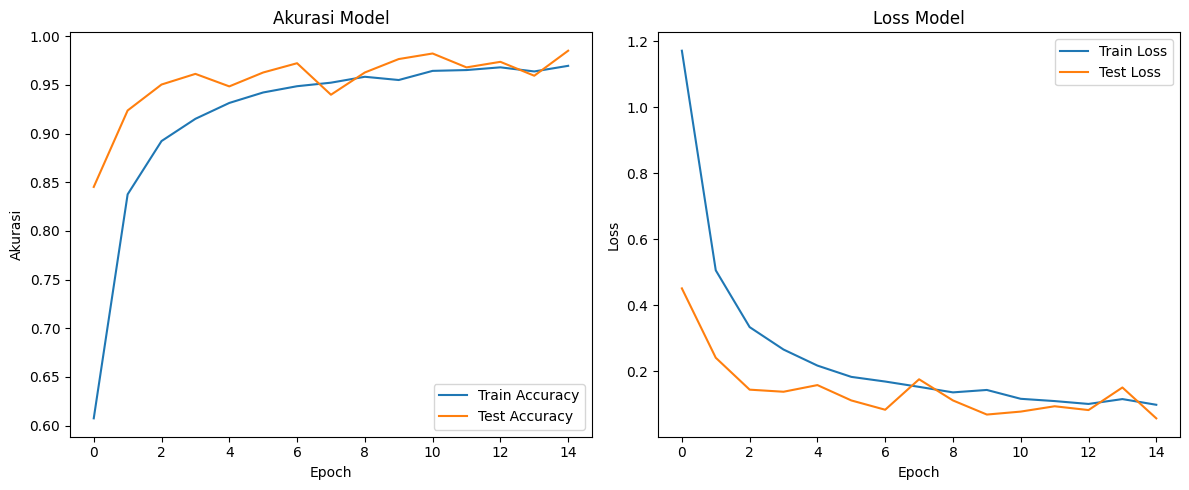

In [14]:
# Plot Akurasi dan Loss dari hasil training
plt.figure(figsize=(12, 5))

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step


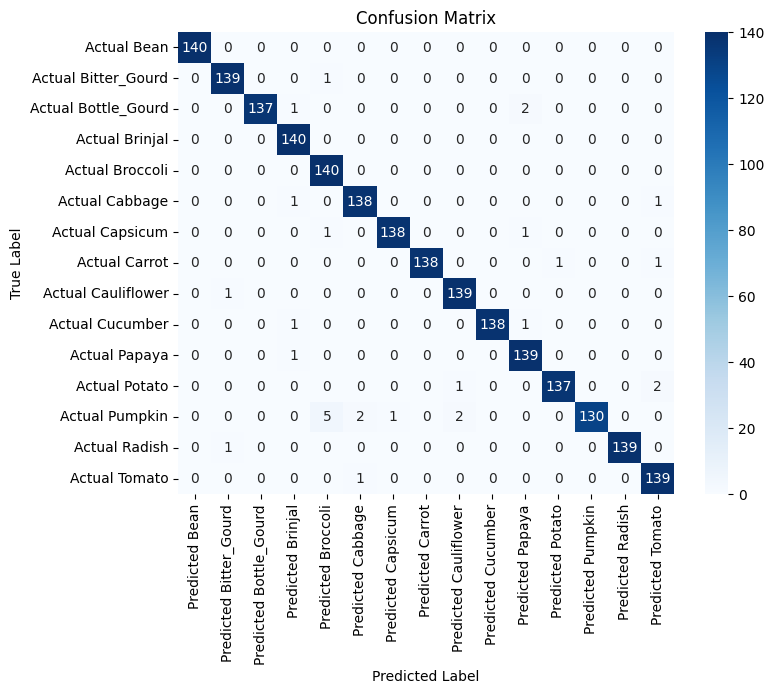


Classification Report:

              precision    recall  f1-score   support

        Bean     1.0000    1.0000    1.0000       140
Bitter_Gourd     0.9858    0.9929    0.9893       140
Bottle_Gourd     1.0000    0.9786    0.9892       140
     Brinjal     0.9722    1.0000    0.9859       140
    Broccoli     0.9524    1.0000    0.9756       140
     Cabbage     0.9787    0.9857    0.9822       140
    Capsicum     0.9928    0.9857    0.9892       140
      Carrot     1.0000    0.9857    0.9928       140
 Cauliflower     0.9789    0.9929    0.9858       140
    Cucumber     1.0000    0.9857    0.9928       140
      Papaya     0.9720    0.9929    0.9823       140
      Potato     0.9928    0.9786    0.9856       140
     Pumpkin     1.0000    0.9286    0.9630       140
      Radish     1.0000    0.9929    0.9964       140
      Tomato     0.9720    0.9929    0.9823       140

    accuracy                         0.9862      2100
   macro avg     0.9865    0.9862    0.9862      2100
w

In [15]:
# Reset generator
test_data.reset()

preds = model.predict(test_data, verbose=1)
pred_classes = np.argmax(preds, axis=1)

# Ground truth dan label
true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(true_classes, pred_classes)
df_cm = pd.DataFrame(cm,
                     index=[f'Actual {label}' for label in class_labels],
                     columns=[f'Predicted {label}' for label in class_labels])

plt.figure(figsize=(8, 6))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(true_classes, pred_classes, target_names=class_labels, digits=4))

In [16]:
# Evaluasi model pada data test
test_loss, test_acc = model.evaluate(test_data, verbose=1)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Evaluasi model pada data train
train_loss, train_acc = model.evaluate(train_data, verbose=1)
print(f"Train Accuracy: {train_acc * 100:.2f}%")
print(f"Train Loss: {train_loss:.4f}")

# Evaluasi model pada data validation
val_loss, val_acc = model.evaluate(val_data, verbose=1)
print(f"val Accuracy: {val_acc * 100:.2f}%")
print(f"val Loss: {val_loss:.4f}")

66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.9856 - loss: 0.0577
Test Accuracy: 98.62%
Test Loss: 0.0542
525/525 ━━━━━━━━━━━━━━━━━━━━ 219s 416ms/step - accuracy: 0.9776 - loss: 0.0669
Train Accuracy: 97.89%
Train Loss: 0.0668
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9838 - loss: 0.0582
val Accuracy: 98.52%
val Loss: 0.0566


In [17]:
print("\n==== Ringkasan Akurasi ====")
print(f"Train Accuracy     : {train_acc * 100:.2f}%")
print(f"Validation Accuracy: {val_acc * 100:.2f}%")
print(f"Test Accuracy      : {test_acc * 100:.2f}%")


==== Ringkasan Akurasi ====
Train Accuracy     : 97.89%
Validation Accuracy: 98.52%
Test Accuracy      : 98.62%


Insight :
1. Train Accuracy (97.89%) \\
Akurasi pada data pelatihan menunjukkan bahwa model mampu mempelajari pola dari data dengan sangat baik, dengan tingkat kesalahan yang rendah. Nilai sebesar 97.89% merupakan indikasi bahwa model telah berhasil mengidentifikasi mayoritas data pelatihan dengan tepat tanpa terlalu menghafal data secara berlebihan.
2. Validation Accuracy (98.52%) \\
Akurasi validasi lebih tinggi dibandingkan data pelatihan (98.52% vs. 97.89%). Meskipun demikian, selisih yang kecil dan akurasi yang tinggi menunjukkan bahwa model memiliki kemampuan generalisasi yang sangat baik selama proses pelatihan dan tuning hyperparameter.
3. Test Accuracy (98.62%) \\
Akurasi pada data uji sebesar 98.62% yang tidak berbeda jauh dengan nilai validasi (98.52%) menandakan bahwa model tidak mengalami overfitting terhadap data pelatihan maupun validasi. Ini juga menunjukkan bahwa model mampu mempertahankan performanya saat dihadapkan pada data yang benar-benar baru dan tidak pernah digunakan dalam proses pelatihan maupun validasi.

## Konversi Model

In [18]:
# Simpan ke SavedModel format (folder)
model.export("saved_model/vegetable_savedmodel")
print("Model disimpan dalam format SavedModel.")

Saved artifact at 'saved_model/vegetable_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 15), dtype=tf.float32, name=None)
Captures:
  137984040913616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137984040914576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137983988721296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137983988720144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137983988720336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137983988720528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137984040913808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137983988720912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137983988722448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137983988723408: TensorSpec(shape=(), dtype=tf.resource, name=None)

In [19]:
# Konversi ke TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan file .tflite
with open("vegetable_tflite.tflite", "wb") as f:
    f.write(tflite_model)

print("Model disimpan dalam format TFLite.")

Saved artifact at '/tmp/tmp0c2mgb3g'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 15), dtype=tf.float32, name=None)
Captures:
  137984040913616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137984040914576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137983988721296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137983988720144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137983988720336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137983988720528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137984040913808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137983988720912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137983988722448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137983988723408: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model disimpan 

In [20]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.5 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [21]:
# Konversi ke tfjs
model.export("saved_model/vegetable_tfjsmodel")
!tensorflowjs_converter --input_format=tf_saved_model saved_model/vegetable_savedmodel saved_model/tfjs_model

Saved artifact at 'saved_model/vegetable_tfjsmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 15), dtype=tf.float32, name=None)
Captures:
  137984040913616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137984040914576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137983988721296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137983988720144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137983988720336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137983988720528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137984040913808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137983988720912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137983988722448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137983988723408: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [22]:
import shutil
from google.colab import files

# Zip SavedModel dan TFJS model
shutil.make_archive("vegetable_savedmodel", 'zip', "saved_model/vegetable_savedmodel")
shutil.make_archive("vegetable_tfjsmodel", 'zip', "saved_model/vegetable_tfjsmodel")

'/content/vegetable_tfjsmodel.zip'

In [23]:
files.download("vegetable_savedmodel.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
files.download("vegetable_tfjsmodel.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [25]:
files.download("vegetable_tflite.tflite")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
# Zip foldernya ke /content/
!zip -r /content/tfjs_model.zip /content/saved_model/tfjs_model

# Download zipnya
from google.colab import files
files.download("/content/tfjs_model.zip")

  adding: content/saved_model/tfjs_model/ (stored 0%)
  adding: content/saved_model/tfjs_model/group1-shard22of22.bin (deflated 6%)
  adding: content/saved_model/tfjs_model/group1-shard4of22.bin (deflated 6%)
  adding: content/saved_model/tfjs_model/group1-shard19of22.bin (deflated 6%)
  adding: content/saved_model/tfjs_model/group1-shard17of22.bin (deflated 6%)
  adding: content/saved_model/tfjs_model/group1-shard13of22.bin (deflated 6%)
  adding: content/saved_model/tfjs_model/group1-shard10of22.bin (deflated 6%)
  adding: content/saved_model/tfjs_model/group1-shard3of22.bin (deflated 6%)
  adding: content/saved_model/tfjs_model/model.json (deflated 88%)
  adding: content/saved_model/tfjs_model/group1-shard9of22.bin (deflated 6%)
  adding: content/saved_model/tfjs_model/group1-shard5of22.bin (deflated 6%)
  adding: content/saved_model/tfjs_model/group1-shard6of22.bin (deflated 6%)
  adding: content/saved_model/tfjs_model/group1-shard20of22.bin (deflated 6%)
  adding: content/saved_mo

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Inference (Optional)

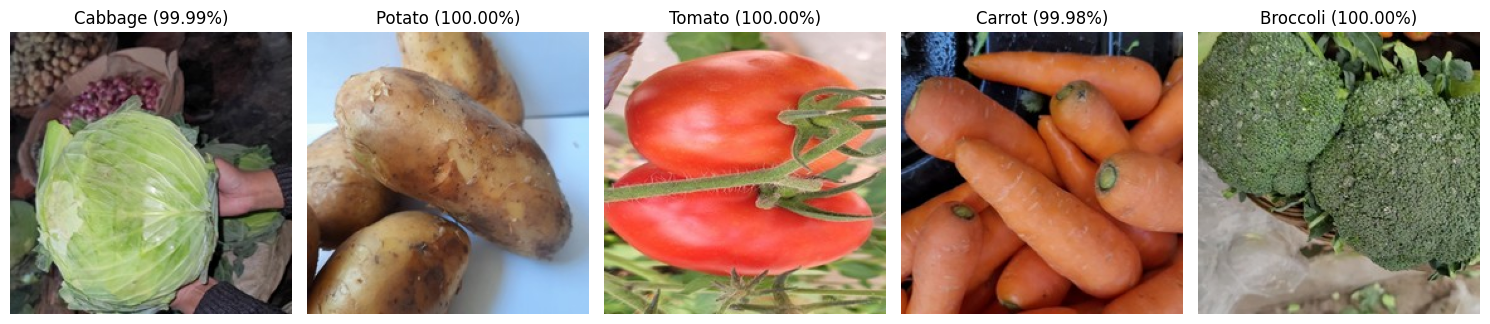

In [28]:
from google.colab import files
import requests
from io import BytesIO

# Daftar link Google Drive
drive_image_links = [
    "https://drive.google.com/uc?id=1lUu0zEyIGG0J5QuTaZfP71z4CrfwrsrO",
    "https://drive.google.com/uc?id=17AxnnwpX1foRkE9fMNx0jli4iRTrBJSe",
    "https://drive.google.com/uc?id=1TOMGmeifyzzygjQsVCGChWiHWbqCWQfb",
    "https://drive.google.com/uc?id=1Mh3df6jopFPo6O1vL2RjYBX6Obk1p6V_",
    "https://drive.google.com/uc?id=1OReI1NidJj-57HsOV9ZmS4Mlz3vkoCp6"
]

# Fungsi untuk mengunduh gambar dari Google Drive link
def download_image(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    return img

# Fungsi untuk memuat dan memproses gambar
def prepare_image(img):
    img = img.resize((224, 224))  # Sesuaikan ukuran jika perlu
    img_array = np.array(img)
    img_array = img_array / 255.0  # Normalisasi
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array.astype(np.float32)  # Pastikan tipe data float32
    return img_array, img

# Load model SavedModel
model = tf.saved_model.load("saved_model/vegetable_savedmodel")
infer = model.signatures["serving_default"]

# Daftar nama kelas
class_labels = [
    "Bean", "Bitter_Gourd", "Bottle_Gourd", "Brinjal", "Broccoli",
    "Cabbage", "Capsicum", "Carrot", "Cauliflower", "Cucumber",
    "Papaya", "Potato", "Pumpkin", "Radish", "Tomato"
]

# Membuat grid untuk menampilkan gambar secara horizontal
fig, axes = plt.subplots(1, len(drive_image_links), figsize=(15, 5))

# Loop untuk memproses gambar dan memprediksi
for i, image_link in enumerate(drive_image_links):
    # Download dan proses gambar
    img_display = download_image(image_link)
    input_image, img_display = prepare_image(img_display)

    # Prediksi
    predictions = infer(tf.convert_to_tensor(input_image))

    # Ambil hasil prediksi
    preds = predictions['output_0'].numpy()
    predicted_index = np.argmax(preds)
    predicted_label = class_labels[predicted_index]
    predicted_confidence = preds[0][predicted_index]

    # Menampilkan gambar dan hasil prediksi di setiap subplot
    axes[i].imshow(img_display)
    axes[i].axis('off')
    axes[i].set_title(f"{predicted_label} ({predicted_confidence:.2%})")

# Tampilkan hasil
plt.tight_layout()
plt.show()

***HASIL INFERENCE :***

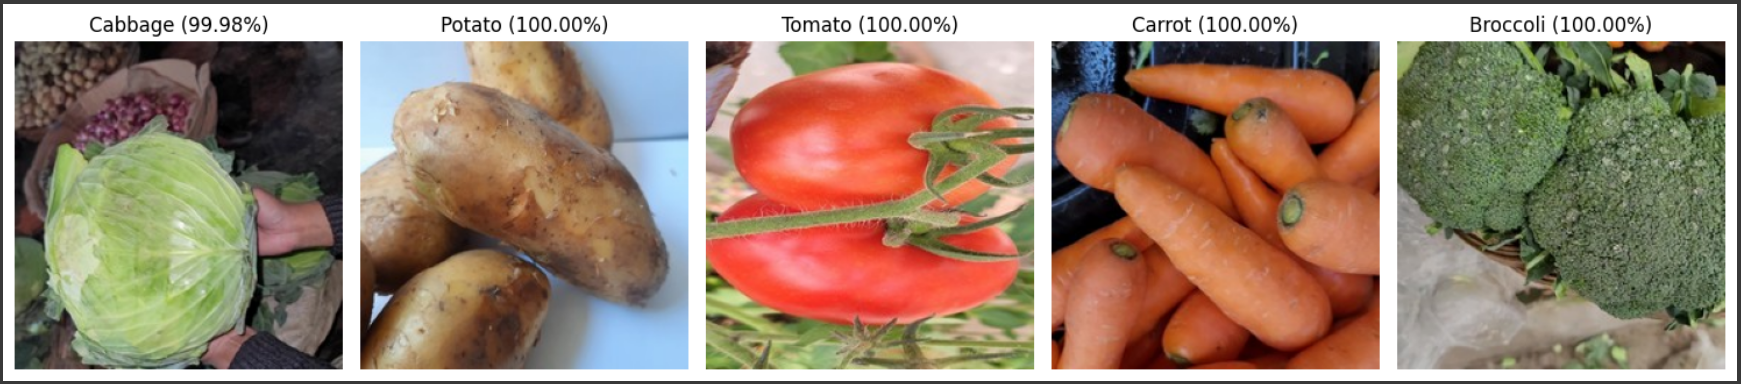

Model belajar dari data yang diberikan sehingga dapat mendeteksi gambar sayur dengan baik. Persentase pada setiap sayur mencapai akurasi yang sangat tinggi sehingga model yang diterapkan mampu menangkap data baru dengan sangat baik. Persentase mungkin saja berubah ketika di run all code, namun selisihnya hanya kecil karena model bekerja dengan baik.